In [179]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import wilcoxon
from scipy.spatial.distance import mahalanobis
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Generate Synthetic Data

Since we don't have access to the actual dataset used in the journal, we replicate the variables that were mentioned.

In [180]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Number of patients
n_patients = 400

# Generate enrollment time in months
enrollment_time = np.random.randint(0, 12, size=n_patients)

# Define possible time points for treatment (e.g., after 3 months, 6 months, etc.)
time_points = np.arange(3, 25, 3)  # Possible treatment times from 3 months to 24 months

# Baseline symptoms (Pain, Urgency, Frequency on a scale of 0-9)
baseline_symptoms = np.random.randint(0, 10, size=(n_patients, 3))

# Generate the "treated" and "treatment time"
treated_indicator = np.zeros(n_patients)  # Initialize all as untreated
treatment_time = np.full(n_patients, np.inf)  # Initialize with np.inf (for untreated patients)

# Simulate simple treatment decision: randomized treatment probability
for i in range(n_patients):
    treat_prob = np.random.uniform(0.1, 0.5)

    # Flip a coin based on the treatment probability (binomial distribution)
    treated = np.random.binomial(1, treat_prob)
    treated_indicator[i] = treated
    
    # If treated, assign a treatment time randomly from the available time points
    if treated:
        treatment_time[i] = np.random.choice(time_points[1:-1])

# Symptoms post-treatment (fluctuate slightly from baseline) Clip to 0-9 scale
treatment_symptoms = np.clip(baseline_symptoms + np.random.randint(-2, 3, size=(n_patients, 3)), 0, 9)

# Follow-up symptoms (Clip to 0-9 scale)
symptoms_3m = np.clip(treatment_symptoms + np.random.randint(0, 3, size=(n_patients, 3)), 0, 9)
symptoms_6m = np.clip(symptoms_3m - np.random.randint(0, 2, size=(n_patients, 3)), 0, 9)

# Gender (0 = Female, 1 = Male)
gender = np.random.choice([0, 1], size=n_patients)

df = pd.DataFrame({
    'Patient_ID': np.arange(1, n_patients + 1),
    'Enrollment_Time': enrollment_time,
    'Treatment_Time': treatment_time,
    'Treated': treated_indicator,
    'base_pain': baseline_symptoms[:, 0],
    'base_urgency': baseline_symptoms[:, 1],
    'base_frequency': baseline_symptoms[:, 2],
    'treatment_pain': treatment_symptoms[:, 0],
    'treatment_urgency': treatment_symptoms[:, 1],
    'treatment_frequency': treatment_symptoms[:, 2],
    'Pain_3M': symptoms_3m[:, 0],
    'Urgency_3M': symptoms_3m[:, 1],
    'Frequency_3M': symptoms_3m[:, 2],
    'Pain_6M': symptoms_6m[:, 0],
    'Urgency_6M': symptoms_6m[:, 1],
    'Frequency_6M': symptoms_6m[:, 2],
    'Gender': gender
})

df.head()


,Patient_ID,Enrollment_Time,Treatment_Time,Treated,base_pain,base_urgency,base_frequency,treatment_pain,treatment_urgency,treatment_frequency,Pain_3M,Urgency_3M,Frequency_3M,Pain_6M,Urgency_6M,Frequency_6M,Gender
0,1,6,6.0,1.0,0,8,5,0,9,7,2,9,7,2,9,7,0
1,2,3,inf,0.0,6,9,6,8,7,5,8,8,6,7,8,5,0
2,3,10,12.0,1.0,9,2,1,8,3,2,8,4,2,7,4,1,1
3,4,7,inf,0.0,8,7,9,9,6,9,9,7,9,8,7,9,0
4,5,4,12.0,1.0,6,8,3,8,8,3,8,9,3,8,8,2,0


In [181]:
df["Treated"].value_counts()

Treated
0.0    270
1.0    130
Name: count, dtype: int64

In [182]:
df.shape

(400, 17)

In [183]:
# Extract treated and control groups
treated = df[df["Treated"] == 1].copy()
control = df[df["Treated"] == 0].copy()

In [184]:
# Standardize covariates for Mahalanobis distance calculation
covariates = ["base_pain", "base_urgency", "base_frequency",
              "treatment_pain", "treatment_urgency", "treatment_frequency"]

scaler = StandardScaler()
treated_scaled = scaler.fit_transform(treated[covariates])
control_scaled = scaler.transform(control[covariates])

# Compute inverse covariance matrix for Mahalanobis distance
cov_matrix = np.cov(treated_scaled.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

In [185]:
# Perform optimal matching
matches = []
used_control_indices = set()

for t_idx, t_row in treated.iterrows():
    # Find eligible control patients (who were enrolled before treatment)
    eligible_controls = control[control["Enrollment_Time"] <= t_row["Treatment_Time"]].copy()
    
    # Remove already matched controls
    eligible_controls = eligible_controls[~eligible_controls.index.isin(used_control_indices)]
    
    if eligible_controls.empty:
        continue  # No eligible controls for this treated patient
    
    # Compute Mahalanobis distances
    distances = []
    t_vector = scaler.transform(pd.DataFrame([t_row[covariates]], columns=covariates))[0]

    
    for c_idx, c_row in eligible_controls.iterrows():
        c_vector = scaler.transform(pd.DataFrame([c_row[covariates]], columns=covariates))[0]

        dist = mahalanobis(t_vector, c_vector, inv_cov_matrix)
        distances.append((dist, c_idx))
    
    # Select the closest control match
    distances.sort()
    best_match = distances[0][1]  # Get the index of the closest match
    
    matches.append((t_idx, best_match))
    used_control_indices.add(best_match)  # Mark this control as used

# Convert matches to DataFrame
matched_pairs = pd.DataFrame(matches, columns=["Treated_Patient", "Control_Patient"])

# Display first few matched pairs
print(matched_pairs.head())


   Treated_Patient  Control_Patient
0                0              296
1                2              129
2                4              195
3                5              265
4                6              397


In [186]:
# Function to compute average Mahalanobis distance
def compute_mahalanobis_dist(group1, group2, covariates):
    X1 = group1[covariates].values
    X2 = group2[covariates].values

    # Standardize data
    scaler = StandardScaler()
    X1_scaled = scaler.fit_transform(X1)
    X2_scaled = scaler.transform(X2)

    # Compute covariance matrix and inverse
    cov_matrix = np.cov(np.vstack((X1_scaled, X2_scaled)).T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Compute Mahalanobis distance for each treated-control pair
    distances = []
    for i in range(len(X1_scaled)):
        dist = mahalanobis(X1_scaled[i], X2_scaled[i % len(X2_scaled)], inv_cov_matrix)
        distances.append(dist)
    
    return np.mean(distances)  # Return average Mahalanobis distance

In [187]:
# Extract treated and control groups
treated = df[df["Treated"] == 1].copy()
control = df[df["Treated"] == 0].copy()

# Compute Mahalanobis distance before matching
mahal_before = compute_mahalanobis_dist(treated, control, covariates)

# Extract matched treated and control patients
treated_matched = df.loc[matched_pairs["Treated_Patient"]]
control_matched = df.loc[matched_pairs["Control_Patient"]]

# Compute Mahalanobis distance after matching
mahal_after = compute_mahalanobis_dist(treated_matched, control_matched, covariates)

# Print Results
print(f"Mahalanobis Distance Before Matching: {mahal_before:.3f}")
print(f"Mahalanobis Distance After Matching: {mahal_after:.3f}")


Mahalanobis Distance Before Matching: 3.350
Mahalanobis Distance After Matching: 1.191


In [188]:
# Function to calculate Standardized Mean Difference (SMD)
def compute_smd(treated_group, control_group, covariates):
    smd_results = {}
    for cov in covariates:
        mean_treated = treated_group[cov].mean()
        mean_control = control_group[cov].mean()
        pooled_std = np.sqrt((treated_group[cov].std()**2 + control_group[cov].std()**2) / 2)
        smd = np.abs(mean_treated - mean_control) / pooled_std
        smd_results[cov] = smd
    return smd_results

In [189]:
# Extract matched treated and control patients
matched_treated = df.loc[matched_pairs["Treated_Patient"]]
matched_control = df.loc[matched_pairs["Control_Patient"]]

# Compute Standardized Mean Differences (SMD)
smd_values = compute_smd(matched_treated, matched_control, covariates)

# Display SMD results
print("\nStandardized Mean Differences (SMD) for Matched Data:")
for cov, smd in smd_values.items():
    print(f"{cov}: {smd:.3f}")

# Check p-values using t-tests
print("\nT-test results (p-values) for matched groups:")
for cov in covariates:
    _, p_value = ttest_ind(matched_treated[cov], matched_control[cov], equal_var=False)
    print(f"{cov}: p-value = {p_value:.3f}")


Standardized Mean Differences (SMD) for Matched Data:
base_pain: 0.008
base_urgency: 0.048
base_frequency: 0.031
treatment_pain: 0.008
treatment_urgency: 0.065
treatment_frequency: 0.021

T-test results (p-values) for matched groups:
base_pain: p-value = 0.947
base_urgency: p-value = 0.700
base_frequency: p-value = 0.806
treatment_pain: p-value = 0.949
treatment_urgency: p-value = 0.600
treatment_frequency: p-value = 0.864


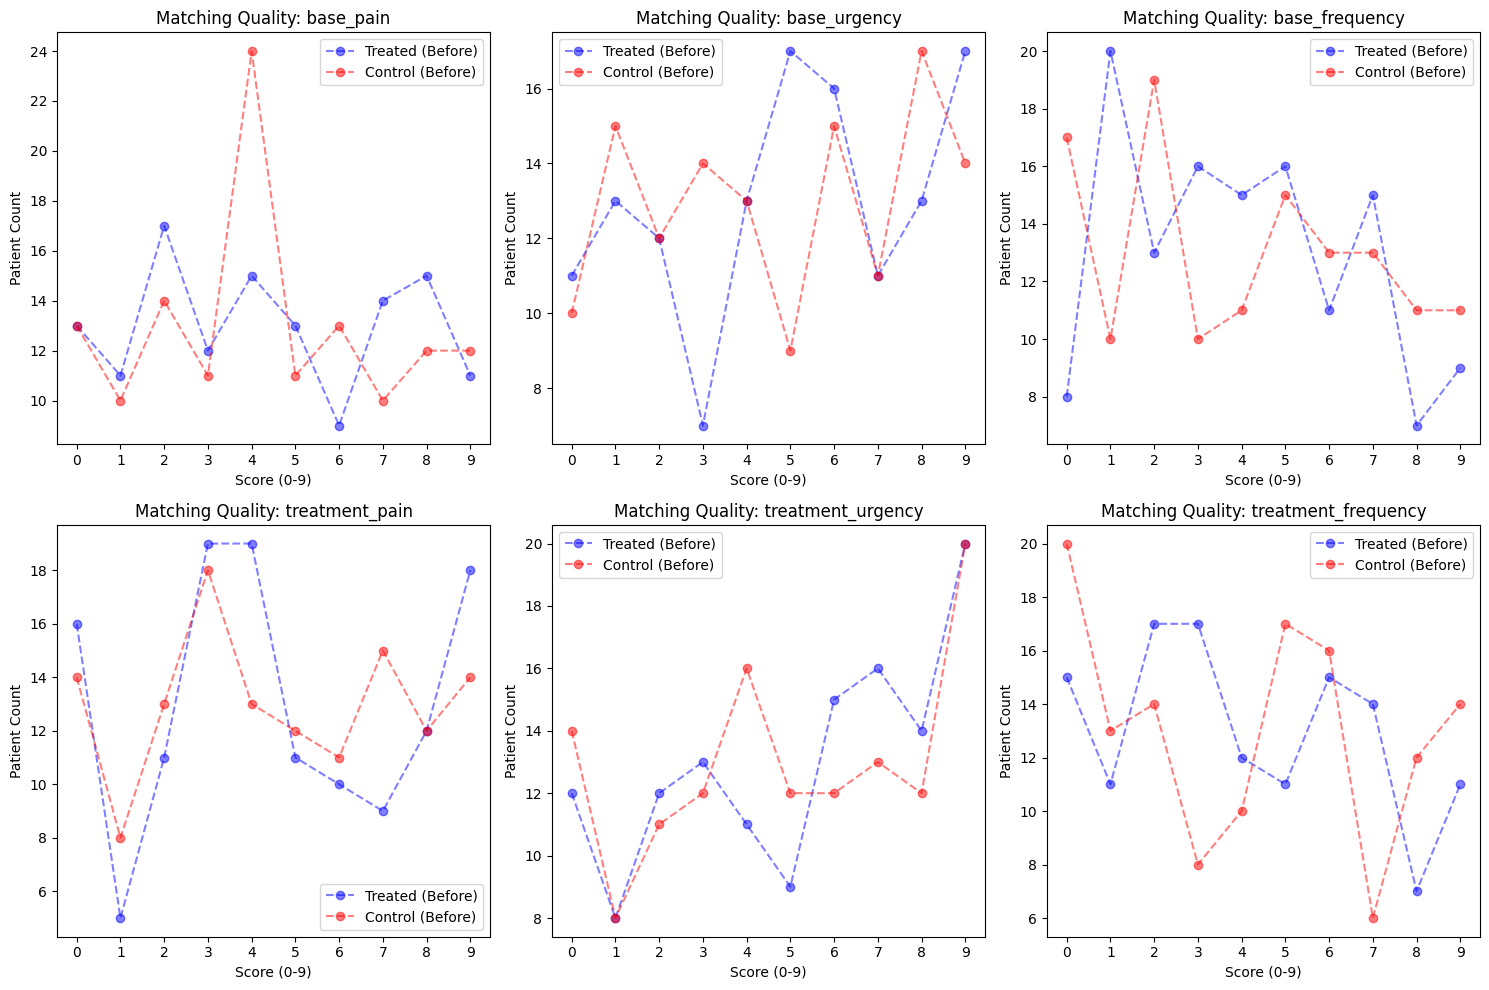

In [190]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, cov in enumerate(covariates):
    # Get distributions
    treated_before = df[df["Treated"] == 1][cov].value_counts().sort_index()
    control_before = df[df["Treated"] == 0][cov].value_counts().sort_index()
    treated_after = matched_treated[cov].value_counts().sort_index()
    control_after = matched_control[cov].value_counts().sort_index()

    # Reindex for consistency
    index_range = range(10)
    treated_before = treated_before.reindex(index_range, fill_value=0)
    control_before = control_before.reindex(index_range, fill_value=0)
    treated_after = treated_after.reindex(index_range, fill_value=0)
    control_after = control_after.reindex(index_range, fill_value=0)

    # Plot as line plots
    axes[i].plot(index_range, treated_after, marker="o", linestyle="--", color="blue", alpha=0.5, label="Treated (Before)")
    axes[i].plot(index_range, control_after, marker="o", linestyle="--", color="red", alpha=0.5, label="Control (Before)")

    # Formatting
    axes[i].set_title(f"Matching Quality: {cov}")
    axes[i].set_xlabel("Score (0-9)")
    axes[i].set_ylabel("Patient Count")
    axes[i].set_xticks(index_range)
    axes[i].legend()

plt.tight_layout()
plt.show()